In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision as tv

from torchvision.datasets import MNIST
from tqdm import tqdm

Загружаем датасет и проводим трансформации над ним: сначала трансформируем каждую картинку в тензор, затем нормализуем с указанными параметрамми мат.ожидания и среднеквадратического отклонения.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

batch_size=128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Строим модель автоэнкодера, три слоя с энкодингом, два слоя с декодингом, в качестве функций активации выступают ReLU, на последнем слое декодинга Sigmoid. \
Создаём экземпляр модели, в качетсве функции потерь выбираем Mean Squared Error, алгоритм оптимизации - Adam, инициализируем гиперпараметры.

In [3]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2)

    def forward(self, x):
        # Encode
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)

        # Decode
        x = nn.functional.relu(self.t_conv1(x))
        x = nn.functional.sigmoid(self.t_conv2(x))

        return x

conv_autoencoder = ConvAutoencoder()
criterion = nn.MSELoss()
learning_rate = 0.01
num_epochs = 5
optimizer = torch.optim.Adam(conv_autoencoder.parameters(), lr=learning_rate)

for epoch in tqdm(range(num_epochs)):
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        output = conv_autoencoder(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

 20%|██        | 1/5 [00:38<02:35, 38.82s/it]

Epoch [1/5], Loss: 0.4570


 40%|████      | 2/5 [01:12<01:46, 35.62s/it]

Epoch [2/5], Loss: 0.4521


 60%|██████    | 3/5 [01:37<01:02, 31.01s/it]

Epoch [3/5], Loss: 0.4491


 80%|████████  | 4/5 [02:15<00:33, 33.72s/it]

Epoch [4/5], Loss: 0.4475


100%|██████████| 5/5 [02:59<00:00, 35.93s/it]

Epoch [5/5], Loss: 0.4468


Обучение было запущено на 5 эпохах, результаты работы сети приведены ниже. Сверху располагаются исходные картинки, снизу - восстановленные автоэнкодером.

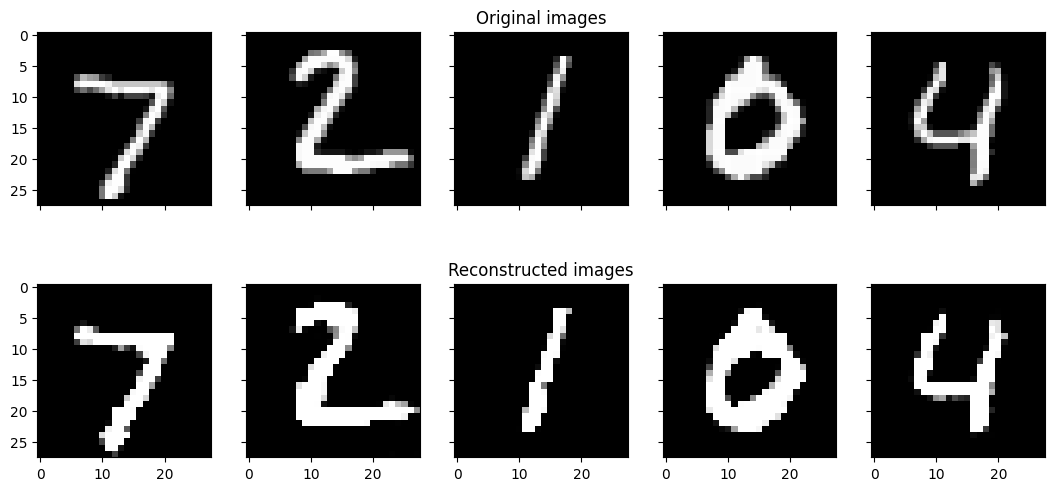

In [4]:
images, labels = next(iter(test_loader))
batch_size = 5
with torch.no_grad():
    reconstructed_images = conv_autoencoder(images)

figure, axes = plt.subplots(nrows=2, ncols=batch_size, sharex=True, sharey=True, figsize=(13, 6))
for i in range(batch_size):
    axes[0][i].imshow(images[i][0], cmap='gray')
    axes[1][i].imshow(reconstructed_images[i][0], cmap='gray')
    if (i == 2):
        axes[0][i].set_title('Original images')
        axes[1][i].set_title('Reconstructed images')
plt.show()